<h1 style="font-size: 36px;">ABDOMINAL TRAUMA DETECTION</h1>


# Overview

Blunt force abdominal trauma is among the most common types of traumatic injury, with the most frequent cause being motor vehicle accidents. There are estimated to be more than 5 million annual deaths worldwide from traumatic injury. Abdominal trauma may result in damage and internal bleeding of the internal organs, including the liver, spleen, kidneys, and bowel. Detection and classification of injuries are key to effective treatment and favorable outcomes. A large proportion of patients with abdominal trauma require urgent surgery. Abdominal trauma often cannot be diagnosed clinically by physical exam, patient symptoms, or laboratory tests.Prompt diagnosis of abdominal trauma using medical imaging is thus critical to patient care.

# Problem Statement

Computed tomography (CT) has become an indispensable tool in evaluating patients with suspected abdominal injuries due to its ability to provide detailed cross-sectional images of the abdomen. Interpreting CT scans for abdominal trauma, however, can be a complex and time-consuming task, especially when multiple injuries or areas of subtle active bleeding are present. This project aims at harnessing the power of machine learning to assist medical professionals in rapidly and precisely detecting injuries and grading their severity

# Objectives

- Using machine learning algorithms to classify abdominal trauma injuries based on the CT scan images
- Meeting a specific accuracy value to ensure it conforms to medical standards

# Data Understanding

The dataset was obtained from Kaggle competition **RSNA 2023 Abdominal Trauma Detection**. The competition is composed of different datasets that contain columns that aid in training the models. The train.csv dataset contains the labels of the various injuries. The image_level_labels.csv dataset is composed of the specific images that contain either the bowel or extravasation injury. The image paths dataset contains paths to the images in the google cloud storage. All the datasets did not have duplicates or missing values.

### Importing necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf

from PIL import Image
from tensorflow.keras.preprocessing import  image
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.applications import ResNet50 
from keras.regularizers import l2
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers

2023-10-24 05:00:40.911558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 05:00:49.244292: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 05:01:07.453984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-24 05:01:07.454484: W tensorflow/strea

### Loading the train.csv dataset


In [4]:
data_train = pd.read_csv('train.csv')

In [5]:
# Displaying the dataset
data_train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [6]:
#Displaying the data types of the columns
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_high            3147 non-null   int64
 8   liver_healthy          3147 non-null   int64
 9   liver_low              3147 non-null   int64
 10  liver_high             3147 non-null   int64
 11  spleen_healthy         3147 non-null   int64
 12  spleen_low             3147 non-null   int64
 13  spleen_high            3147 non-null   int64
 14  any_injury             3147 non-null   int64
dtypes: int64(15)
memory usage: 368.9 KB


All columns are of the type integer and contain no missing values

In [7]:
# Creating a class to perform data understanding

class DataChecker:
    def __init__(self,data):
        self.data = data
        
    def check_missing_values(self):
        
        missing_values = self.data.isnull().sum()
        
        if missing_values.sum() > 0:
            print('Missing values: ', missing_values[missing_values>0])
            
        else:
            print('Dataset contains no missing values')
    
    def check_duplicates(self):
        
        duplicate_rows = self.data[self.data.duplicated()]
        
        if not duplicate_rows.empty:
            print('Duplicate rows:')
            print(duplicate_rows)
            
        else:
            print('No duplicate rows found in the dataset')
            

In [8]:
if __name__ == "__main__":

    checker = DataChecker(data_train)
    
    checker.check_missing_values()
    
    checker.check_duplicates()

Dataset contains no missing values
No duplicate rows found in the dataset


### Loading the image_level_labels.csv dataset

In [9]:

data_labels = pd.read_csv('image_level_labels.csv')

data_labels.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


In [10]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       12029 non-null  int64 
 1   series_id        12029 non-null  int64 
 2   instance_number  12029 non-null  int64 
 3   injury_name      12029 non-null  object
dtypes: int64(3), object(1)
memory usage: 376.0+ KB


In [11]:
data_labels['injury_name'].value_counts()

Active_Extravasation    6370
Bowel                   5659
Name: injury_name, dtype: int64

In [12]:
if __name__ == "__main__":

    checker = DataChecker(data_labels)
    
    checker.check_missing_values()
    
    checker.check_duplicates()

Dataset contains no missing values
No duplicate rows found in the dataset


In [13]:
data_train['patient_id'].nunique()

3147


### Loading the Image Paths Dataset

In [14]:

data_images = pd.read_csv('modified_images_train.csv')

In [15]:
data_images.head()

,gs://lucid_diode_397317_rsna/image_path
0,gs://lucid-diode-397317_rsna/train_images/1093...
1,gs://lucid-diode-397317_rsna/train_images/1093...
2,gs://lucid-diode-397317_rsna/train_images/1093...
3,gs://lucid-diode-397317_rsna/train_images/1093...
4,gs://lucid-diode-397317_rsna/train_images/1093...


In [16]:


# Obtaining the Patient ID, Series Number, Instance Number
data_images[['patient_id', 'series_no.', 'instance_no.']] = data_images['gs://lucid_diode_397317_rsna/image_path'].str.extract(r'/train_images/(\d+)/(\d+)/(\d+)')

data_images = pd.DataFrame(data_images)
data_images.head()

,gs://lucid_diode_397317_rsna/image_path,patient_id,series_no.,instance_no.
0,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,100
1,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,101
2,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,102
3,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,103
4,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,104


In [17]:
data_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23152 entries, 0 to 23151
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   gs://lucid_diode_397317_rsna/image_path  23152 non-null  object
 1   patient_id                               23152 non-null  object
 2   series_no.                               23152 non-null  object
 3   instance_no.                             23152 non-null  object
dtypes: object(4)
memory usage: 723.6+ KB


In [18]:
# Coverting the type of the patient id 
data_images['patient_id'] = data_images['patient_id'].astype('int')

### Merging Datasets

Merging the train.csv, image_level_labels.csv and image_paths.csv datasets was done to assign the images labels using the patient_id column.

In [19]:
merged_df = data_train.merge(data_labels, on = 'patient_id')
merged_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation


In [20]:
# Displaying the shape of the merged dataframe
merged_df.shape

(12029, 18)

In [21]:
# Confirming the unique values in the patient id column
merged_df['patient_id'].value_counts()

46022    410
19742    371
53581    350
11925    337
63113    282
        ... 
19249      1
36686      1
61530      1
14018      1
1675       1
Name: patient_id, Length: 246, dtype: int64

In [22]:
# Merging the dataset with the image paths dataset
merged_df_final = data_images.merge(merged_df, on=['patient_id'],how='left')

In [23]:
merged_df_final.head()

,gs://lucid_diode_397317_rsna/image_path,patient_id,series_no.,instance_no.,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,...,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,101,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,104,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Filling in the missing values
merged_df_final = merged_df_final.bfill()

In [25]:
merged_df_final.shape

(35114, 21)

In [26]:
# Checking for duplicates and missing values in the merged dataset
if __name__ == "__main__":

    checker = DataChecker(merged_df_final)
    
    checker.check_missing_values()
    
    checker.check_duplicates()

Missing values:  bowel_healthy            4160
bowel_injury             4160
extravasation_healthy    4160
extravasation_injury     4160
kidney_healthy           4160
kidney_low               4160
kidney_high              4160
liver_healthy            4160
liver_low                4160
liver_high               4160
spleen_healthy           4160
spleen_low               4160
spleen_high              4160
any_injury               4160
series_id                4160
instance_number          4160
injury_name              4160
dtype: int64
No duplicate rows found in the dataset


The dataset contained a number of missing values after the merge. The missing values were filled using the forward fill method.

In [27]:
# Filling in missing values
merged_df_final.ffill()

,gs://lucid_diode_397317_rsna/image_path,patient_id,series_no.,instance_no.,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,...,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,100,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
1,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,101,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
2,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,102,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
3,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,103,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
4,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,104,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35109,gs://lucid-diode-397317_rsna/train_images/7933...,7933,2859,239,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,51596.0,98.0,Bowel
35110,gs://lucid-diode-397317_rsna/train_images/7933...,7933,2859,240,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,51596.0,98.0,Bowel
35111,gs://lucid-diode-397317_rsna/train_images/7933...,7933,2859,241,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,51596.0,98.0,Bowel
35112,gs://lucid-diode-397317_rsna/train_images/7933...,7933,2859,242,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,51596.0,98.0,Bowel


In [28]:
# Renaming the image paths column name
merged_df_final.rename(columns={'gs://lucid_diode_397317_rsna/image_path':'image_paths'}, inplace=True)

In [29]:
merged_df_final.head()

,image_paths,patient_id,series_no.,instance_no.,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,...,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,100,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
1,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,101,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
2,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,102,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
3,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,103,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
4,gs://lucid-diode-397317_rsna/train_images/1093...,10937,12039,104,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation


# Exploratory Data Analysis

This section involves creating visualizations to provide a deeper understanding of the data. The distribution of injuries was investigated, an image from the dataset was visualized and a countplot was generated for each injury

### Checking for the distribution of injuries in the dataset

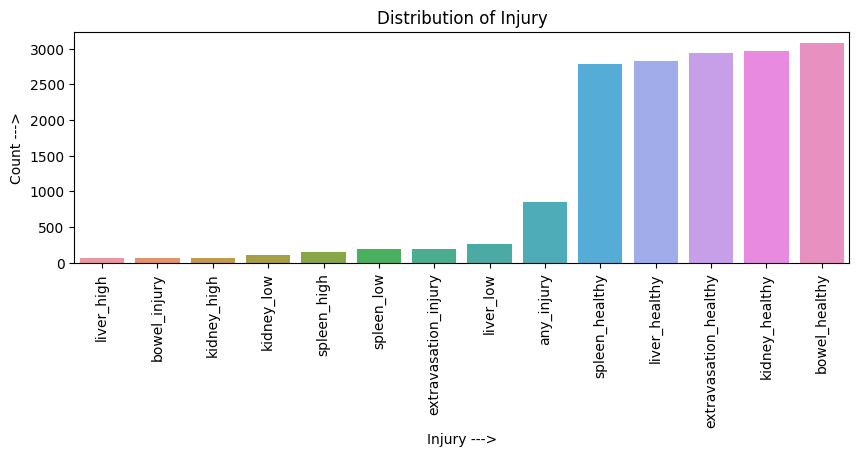

In [30]:

organ_counts = pd.DataFrame()

organ_counts['Organ'] = data_train.columns[1:]
organ_counts['counts'] = [0 for _ in range(organ_counts.shape[0])]

for index,column in enumerate(data_train.columns[1:]):
        organ_counts['counts'][index] = data_train[column].sum()
        
plt.figure(figsize=(10,3))
sns.barplot(organ_counts.sort_values(by=['counts']), x= 'Organ', y = 'counts')

plt.xticks(rotation=90)
plt.title("Distribution of Injury")
plt.xlabel("Injury --->")
plt.ylabel("Count --->")
plt.show()

The following insights can be obtained from the above visualization; healthy organs had more values compared to injured organs. Bowel healthy was the highest and liver_high(meaning a high severity of the injury) the lowest.

### Displaying one CT scan image

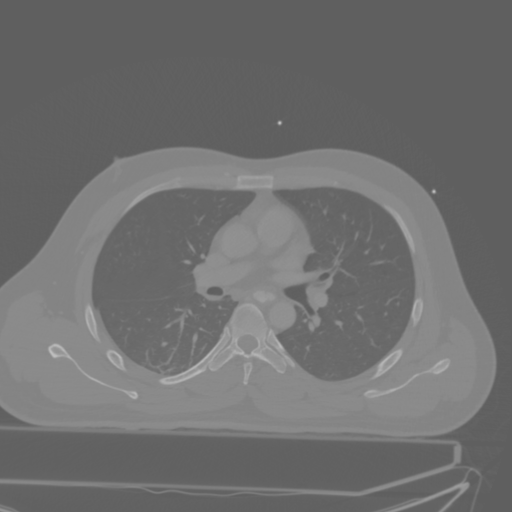

In [31]:
# Specify the path to the locally copied image
image_path = 'lucid-diode-397317_rsna/train_images/10937/12039/100.png'  # Replace with the actual path

# Display the image
display(Image(filename=image_path))


The images are clear and in the expected quality

In [32]:
# Stripping part of the image paths
merged_df_final['image_paths'] = merged_df_final['image_paths'].str.replace('gs://','')

In [33]:
merged_df_final.head()

,image_paths,patient_id,series_no.,instance_no.,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,...,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,100,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
1,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,101,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
2,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,102,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
3,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,103,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation
4,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,104,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,242.0,28.0,Active_Extravasation


In [34]:
merged_df_final.shape

(35114, 21)

In [35]:
# Dropping unwanted columns 
merged_df_final = merged_df_final.drop(columns=['series_id','instance_number'],axis=1)

In [36]:
merged_df_final.shape

(35114, 19)

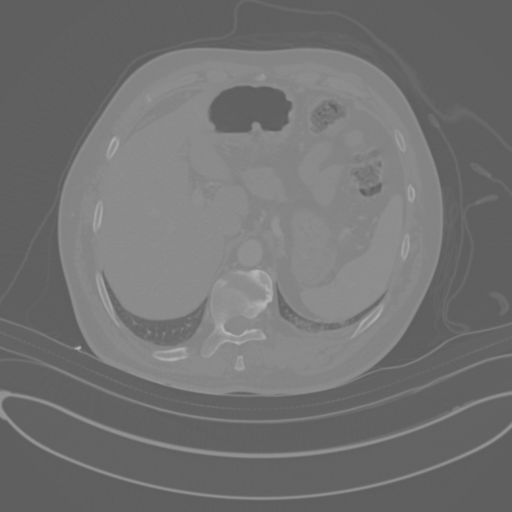

In [37]:
# Specifying the path to the locally copied image
image_path = merged_df_final.loc[1000, 'image_paths']  

# Display the image
display(Image(filename=image_path))

### Generating a countplot for the various injuries

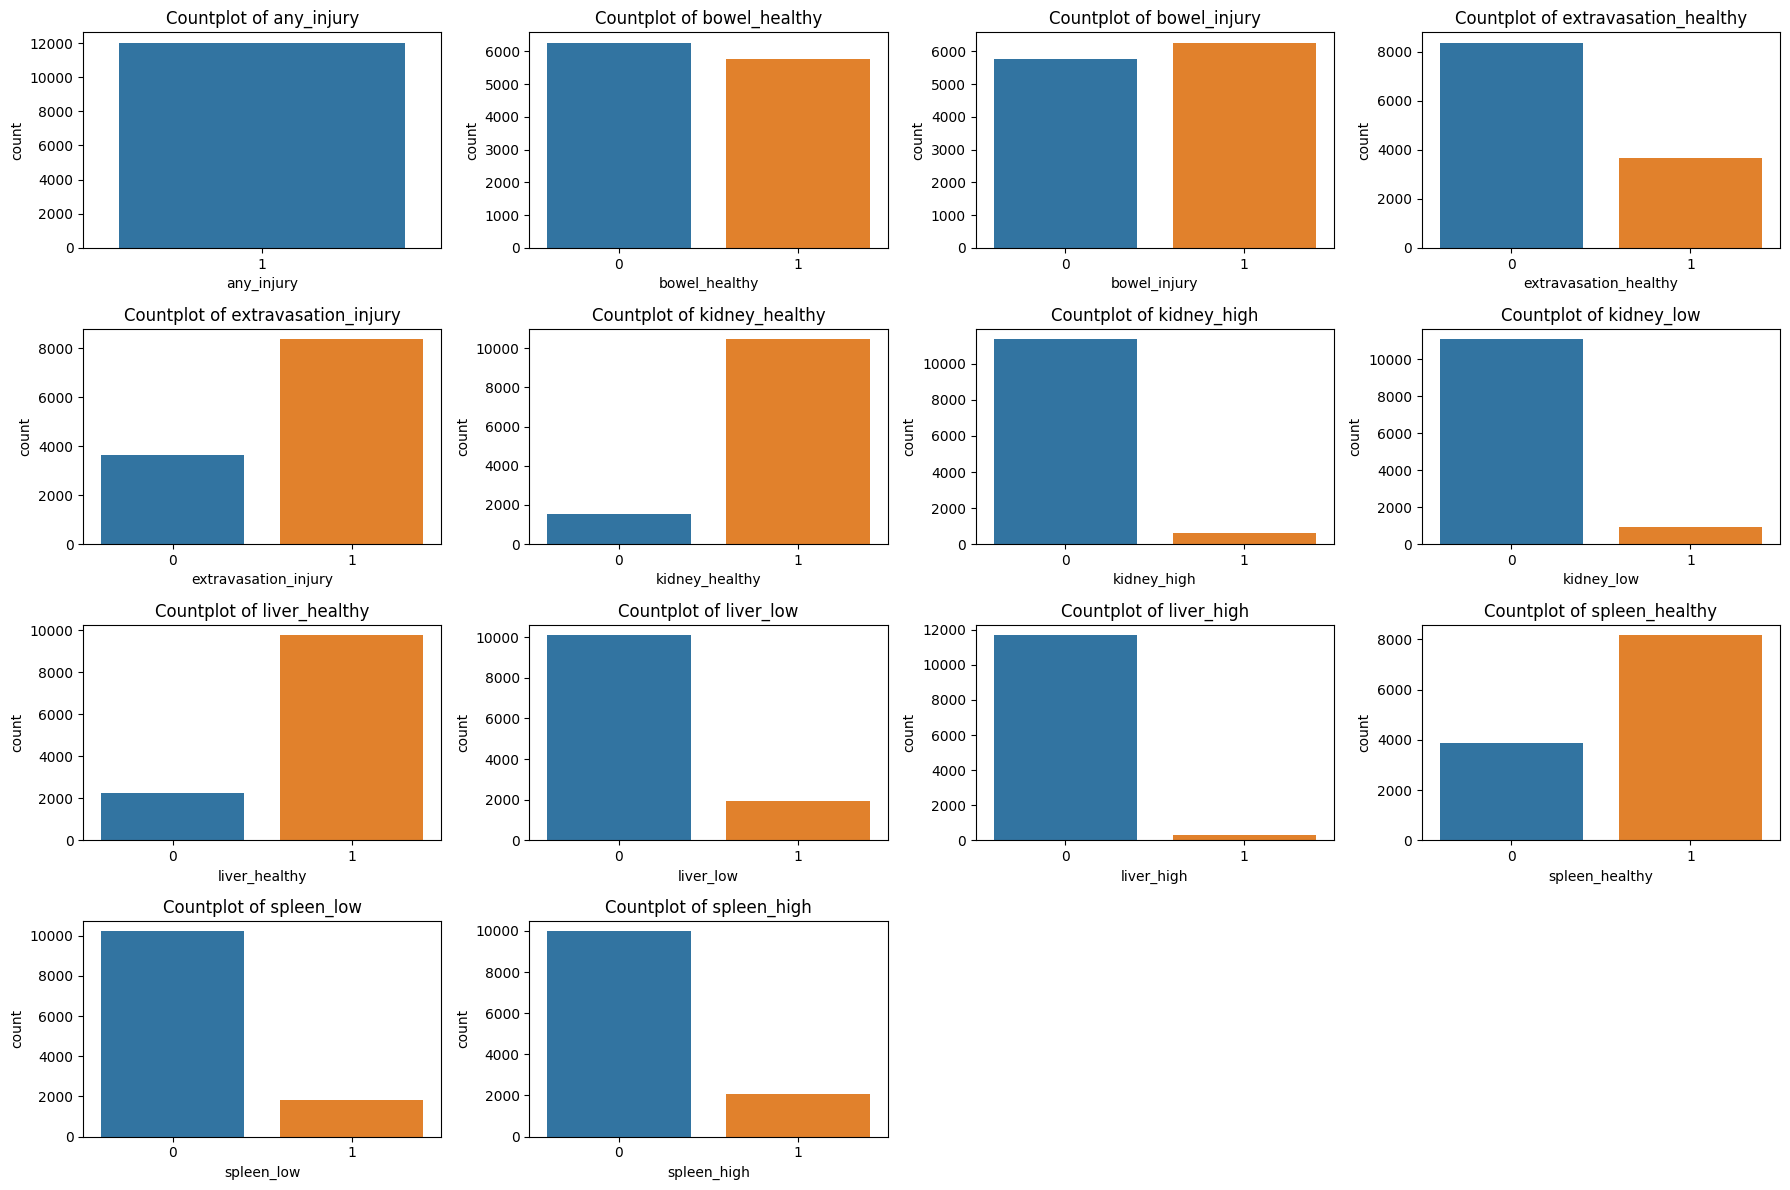

In [38]:
# Plotting count plots for columns with binary values (0 or 1)
binary_columns = ['any_injury', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy', 'extravasation_injury',
                   'kidney_healthy', 'kidney_high', 'kidney_low', 'liver_healthy', 'liver_low', 'liver_high',
                   'spleen_healthy', 'spleen_low', 'spleen_high']

plt.figure(figsize=(18, 12))
for col in binary_columns:
    plt.subplot(4, 4, binary_columns.index(col) + 1)
    sns.countplot(x=col, data=merged_df)
    plt.title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

The visualization above shows the distribution of the binary targets for each organ depending on whether the severity of the injury is high, low or the organ is healthy.

# Modeling

In this section the dataset was split into train, test and validation sets.  Convolutional Neural Networks were used to generate the first and second model. Transfer learning models such as RESNET50 and VGG were also used to train the models.

In [39]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35114 entries, 0 to 35113
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image_paths            35114 non-null  object 
 1   patient_id             35114 non-null  int64  
 2   series_no.             35114 non-null  object 
 3   instance_no.           35114 non-null  object 
 4   bowel_healthy          30954 non-null  float64
 5   bowel_injury           30954 non-null  float64
 6   extravasation_healthy  30954 non-null  float64
 7   extravasation_injury   30954 non-null  float64
 8   kidney_healthy         30954 non-null  float64
 9   kidney_low             30954 non-null  float64
 10  kidney_high            30954 non-null  float64
 11  liver_healthy          30954 non-null  float64
 12  liver_low              30954 non-null  float64
 13  liver_high             30954 non-null  float64
 14  spleen_healthy         30954 non-null  float64
 15  sp

In [40]:
merged_df_final.head()

,image_paths,patient_id,series_no.,instance_no.,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,injury_name
0,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,100,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Active_Extravasation
1,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,101,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Active_Extravasation
2,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,102,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Active_Extravasation
3,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,103,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Active_Extravasation
4,lucid-diode-397317_rsna/train_images/10937/120...,10937,12039,104,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Active_Extravasation


### Preprocessing the images

Before generating the models, the images had to be preprocessed to match the dimensions required as input by the models. The preprocessing involved resizing the images to a specified target size (224 by 224) to ensure uniformity

In [41]:
# Helper function to preprocess the images
def load_image_and_resize(image_path, target_size=(224,224)):
   
    img1 = Image.open(image_path)
    img = img1.resize(target_size, Image.ANTIALIAS)
    
    return img

In [42]:
# Applying the function to the images in the dataset
from PIL import Image

images= []
for image_path in merged_df_final['image_paths']:
    resized_image = load_image_and_resize(image_path)
    images.append(np.array(resized_image))
images = [np.array(image) for image in images]

# Converting the list of images to a NumPy array
images = np.array(images, dtype=np.float32)

### Performing image normalization in batches

Image normalization was performed in batches to enhance efficiency since processing one image at a time can be slow and inefficient. It also ensures consistency as the same set of operations can be applied to all the images.

In [43]:
#Preprocessing the images
batch_size = 32
num_images = images.shape[0]

for start_idx in range(0, num_images, batch_size):
    end_idx = min(start_idx + batch_size, num_images)
    
    batch = images[start_idx:end_idx]
    
    batch = batch/255.0
    
    images[start_idx:end_idx] = batch

In [44]:
#Checking the shape of the images
print(images.shape)

(35114, 224, 224)


In [45]:
#Filling in missing values 
merged_df_final.ffill(inplace=True)

In [46]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35114 entries, 0 to 35113
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image_paths            35114 non-null  object 
 1   patient_id             35114 non-null  int64  
 2   series_no.             35114 non-null  object 
 3   instance_no.           35114 non-null  object 
 4   bowel_healthy          35114 non-null  float64
 5   bowel_injury           35114 non-null  float64
 6   extravasation_healthy  35114 non-null  float64
 7   extravasation_injury   35114 non-null  float64
 8   kidney_healthy         35114 non-null  float64
 9   kidney_low             35114 non-null  float64
 10  kidney_high            35114 non-null  float64
 11  liver_healthy          35114 non-null  float64
 12  liver_low              35114 non-null  float64
 13  liver_high             35114 non-null  float64
 14  spleen_healthy         35114 non-null  float64
 15  sp

### Assing the target colums to y and the feature column to x variable

The images which are the features were assigned to X and the target columns were assigned to y for modeling

In [47]:
X = images
y = merged_df_final[['any_injury','bowel_healthy' , 'bowel_injury','extravasation_healthy', 'extravasation_injury',
        'kidney_healthy','kidney_high','kidney_low', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 
                     'spleen_low','spleen_high']]
print(y.head())

   any_injury  bowel_healthy  bowel_injury  extravasation_healthy  \
0         1.0            1.0           0.0                    0.0   
1         1.0            1.0           0.0                    0.0   
2         1.0            1.0           0.0                    0.0   
3         1.0            1.0           0.0                    0.0   
4         1.0            1.0           0.0                    0.0   

   extravasation_injury  kidney_healthy  kidney_high  kidney_low  \
0                   1.0             1.0          0.0         0.0   
1                   1.0             1.0          0.0         0.0   
2                   1.0             1.0          0.0         0.0   
3                   1.0             1.0          0.0         0.0   
4                   1.0             1.0          0.0         0.0   

   liver_healthy  liver_low  liver_high  spleen_healthy  spleen_low  \
0            1.0        0.0         0.0             1.0         0.0   
1            1.0        0.0       

In [48]:
print(X.shape, y.shape)

(35114, 224, 224) (35114, 14)


### Splitting the x and y variables in batches

The dataset was split into train, test and validation sets for training and testing the model. The reason for this was to leverage parallelism and make better use of hardware resources

In [49]:
# Defining the batch size
batch_size = 32

# Getting the indices of data points with non-absent labels 
valid_indices = np.where(y['any_injury'] == 1)[0]

# Shuffling the valid indices
np.random.shuffle(valid_indices)

# Calculating the number of batches for the valid data points
num_batches = len(valid_indices) // batch_size

# Defining proportions for train, validation, and test sets
train_proportion = 0.7  # 70% for training
validation_proportion = 0.15  # 15% for validation
test_proportion = 0.15  # 15% for testing

# Calculating the number of batches for each set
num_train_batches = int(train_proportion * num_batches)
num_validation_batches = int(validation_proportion * num_batches)
num_test_batches = num_batches - num_train_batches - num_validation_batches

# Splitting batch indices into train, validation, and test sets
train_batch_indices = valid_indices[:num_train_batches * batch_size]
validation_batch_indices = valid_indices[num_train_batches * batch_size:(num_train_batches + num_validation_batches) * batch_size]
test_batch_indices = valid_indices[(num_train_batches + num_validation_batches) * batch_size:]


X_train_batches = [np.expand_dims(X[i], axis=-1) for i in train_batch_indices]
y_train_batches = [y.iloc[i] for i in train_batch_indices]

X_validation_batches = [np.expand_dims(X[i], axis=-1) for i in validation_batch_indices]
y_validation_batches = [y.iloc[i] for i in validation_batch_indices]

X_test_batches = [np.expand_dims(X[i], axis=-1) for i in test_batch_indices]
y_test_batches = [y.iloc[i] for i in test_batch_indices]

In [48]:
len(X_validation_batches)

5248

## Model 1 - Convolutional Neural Network Model

A CNN model was generated using the Keras library. It uses a 2D convolution layer to perform convolutions and extract features from the images.

In [48]:

# Creating a Sequential model
model = models.Sequential()

# Add a Conv2D layer with a single channel (1) 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))


# Add a Flatten layer to prepare for the fully connected layers
model.add(layers.Flatten())


model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14, activation='sigmoid'))  # Output layer for multi-label classification

learning_rate = 0.001  

# Create the RMSprop optimizer with the specified learning rate
optimizer = optimizers.RMSprop(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


2023-10-21 11:13:26.091815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-21 11:13:26.091872: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-21 11:13:26.091923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d1ebb888ff8e): /proc/driver/nvidia/version does not exist
2023-10-21 11:13:26.092435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 64)                100933696 
                                                                 
 dense_1 (Dense)             (None, 14)                910       
                                                                 
Total params: 100,934,926
Trainable params: 100,934,926
Non-trainable params: 0
_________________________________________________________________


In [49]:
results1 = model.fit(
            np.array(X_train_batches), 
            np.array(y_train_batches),  # Use the modified binary labels
            epochs=20, 
            validation_data=(np.array(X_validation_batches), np.array(y_validation_batches)),
            verbose=1
)


Epoch 1/20


2023-10-21 11:13:30.608554: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4926078976 exceeds 10% of free system memory.


767/767 [==============================] - 495s 644ms/step - loss: 0.2173 - accuracy: 0.5127 - val_loss: 1.3999e-04 - val_accuracy: 0.6810
Epoch 2/20
767/767 [==============================] - 470s 613ms/step - loss: 0.0320 - accuracy: 0.3081 - val_loss: 4.9039e-05 - val_accuracy: 0.0488
Epoch 3/20
767/767 [==============================] - 466s 607ms/step - loss: 0.0255 - accuracy: 0.2170 - val_loss: 3.4597e-05 - val_accuracy: 0.0938
Epoch 4/20
767/767 [==============================] - 464s 604ms/step - loss: 0.0241 - accuracy: 0.0933 - val_loss: 1.2021e-05 - val_accuracy: 0.2643
Epoch 5/20
767/767 [==============================] - 453s 590ms/step - loss: 0.0151 - accuracy: 0.4364 - val_loss: 3.1858e-06 - val_accuracy: 0.6460
Epoch 6/20
767/767 [==============================] - 454s 592ms/step - loss: 0.0195 - accuracy: 0.4161 - val_loss: 2.9009e-05 - val_accuracy: 0.0806
Epoch 7/20
767/767 [==============================] - 451s 588ms/step - loss: 0.0080 - accuracy: 0.2132 - val_l

In [53]:
def visualizing_training_results(result):
    history = result.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy','accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

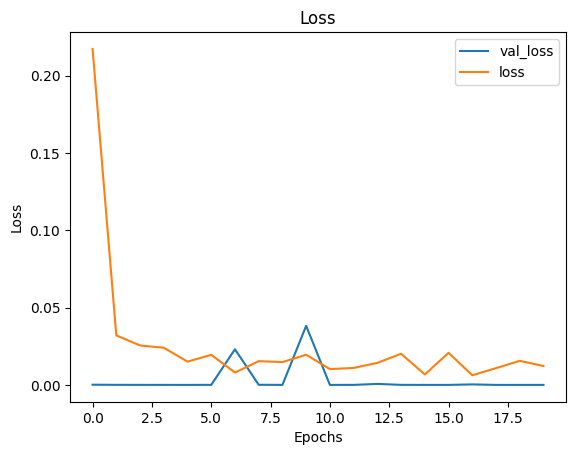

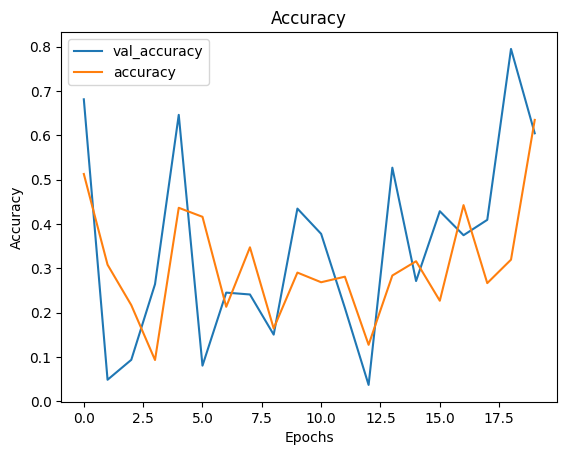

In [51]:
visualizing_training_results(results1)

From the above plots the following insights can be obtained:
- The validation accuracy is starting at a higher value than the training accuracy showing that the model is not only memorizing the training data but also picking up general patterns from the beginning of training
- The fluctuations are many meaning that the model performance is not stable throughout the training.
- Both losses are sufficiently low  
- The training and validation accuracies are however not converging
- The model is not overfitting

In [52]:
test_loss, test_accuracy = model.evaluate(np.array(X_test_batches),np.array( y_test_batches))
print('Test loss', test_loss)
print('Test accuracy', test_accuracy)

167/167 [==============================] - 18s 107ms/step - loss: 2.3753e-06 - accuracy: 0.6088
Test loss 2.375281383137917e-06
Test accuracy 0.6087936758995056


The test loss is very low which indicates that the model prediction are very close to the true labels. It suggests that the model is making highly accurate predictions. An accuracy of approximately 0.61 suggest that the model is only able to classify 61% of the test data correctly, which is very low.

## Model 2 - Hyperparameter Tuning Convolutional Neural Network Model 

As compared to Model 1, I used a different optimizer called adam to see if there will be an improvement in model performance.

In [96]:
# Creating a Sequential model
model2 = models.Sequential()

# Add a Conv2D layer with a single channel (1) 
model2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 1)))

# Adding a Flatten layer to prepare for the fully connected layers
model2.add(layers.Flatten())

model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(14, activation='sigmoid'))  # Output layer for multi-label classification

learning_rate = 0.001  

# Create the RMSprop optimizer with the specified learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

2023-10-22 13:09:39.002475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-22 13:09:39.029253: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-22 13:09:39.029412: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c588b4699287): /proc/driver/nvidia/version does not exist
2023-10-22 13:09:39.054023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 flatten (Flatten)           (None, 3154176)           0         
                                                                 
 dense (Dense)               (None, 64)                201867328 
                                                                 
 dense_1 (Dense)             (None, 14)                910       
                                                                 
Total params: 201,868,878
Trainable params: 201,868,878
Non-trainable params: 0
_________________________________________________________________


In [97]:
results2 = model2.fit(
           np.array(X_train_batches), 
           np.array(y_train_batches),epochs=20,
           validation_data=(np.array(X_validation_batches), np.array(y_validation_batches)),
           verbose=1
)


2023-10-22 13:09:43.495906: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4926078976 exceeds 10% of free system memory.


Epoch 1/20
767/767 [==============================] - 581s 753ms/step - loss: 0.0729 - accuracy: 0.4305 - val_loss: 4.2637e-04 - val_accuracy: 0.5558
Epoch 2/20
767/767 [==============================] - 574s 749ms/step - loss: 2.1530e-04 - accuracy: 0.5653 - val_loss: 5.7108e-05 - val_accuracy: 0.5680
Epoch 3/20
767/767 [==============================] - 573s 747ms/step - loss: 0.0077 - accuracy: 0.5944 - val_loss: 6.5298e-05 - val_accuracy: 0.5915
Epoch 4/20
767/767 [==============================] - 574s 749ms/step - loss: 4.5389e-05 - accuracy: 0.5975 - val_loss: 2.2080e-05 - val_accuracy: 0.5800
Epoch 5/20
767/767 [==============================] - 575s 750ms/step - loss: 1.6664e-05 - accuracy: 0.5868 - val_loss: 2.5662e-05 - val_accuracy: 0.5837
Epoch 6/20
767/767 [==============================] - 572s 746ms/step - loss: 8.8175e-06 - accuracy: 0.5903 - val_loss: 7.4742e-06 - val_accuracy: 0.5789
Epoch 7/20
767/767 [==============================] - 576s 751ms/step - loss: 5.2137

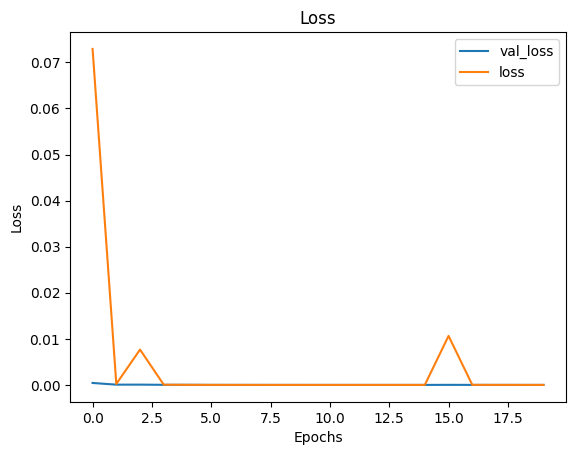

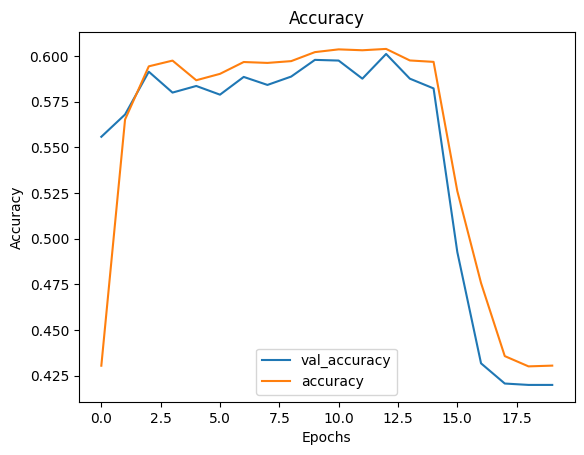

In [99]:
visualizing_training_results(results2)

The interpretation of the model is as follows:
- Both the validation loss and training loss plateau and achieve close cnvergence indicating that the model has reached optimal performance.
- The gap between the validation accuracy and the training accuracy is small which indicates that the model is generalizing well and not overfitting
- The drop in accuracy for both the validation and training might be because of the batches which may affect the training dynamics 


In [54]:
test_loss, test_accuracy = model2.evaluate(np.array(X_test_batches),np.array( y_test_batches))
print('Test loss', test_loss)
print('Test accuracy', test_accuracy)

167/167 [==============================] - 12s 72ms/step - loss: 2.1494e-05 - accuracy: 0.5034
Test loss 2.149435385945253e-05
Test accuracy 0.5033822059631348


A 50% accuracy in the test set is higher compared to model 1. The model's performance has improved.

## Model 3 - RESNET50 Transfer Learning Model

The use of RESNET50 for image classification was considered since it provides a deep neural network architecture. It also effectively captures complex features and hierarchies in images

In [50]:
# Initializing the resnet model
num_classes = 14

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Adding custom classification layers on top of the pre-trained model
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
output = keras.layers.Dense(num_classes, activation='softmax')(x)

model3 = keras.Model(inputs=base_model.input, outputs=output)

learning_rate = 0.001  

# Create the RMSprop optimizer with the specified learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)


# Compiling the model
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

2023-10-23 12:57:41.875690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-23 12:57:41.875748: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-23 12:57:41.875795: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5387e68f5ed4): /proc/driver/nvidia/version does not exist
2023-10-23 12:57:41.876057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

### Converting the images to RGB for modeling

To ensure compatibility with the transfer learning models the training, validation and test images had to be converted from grayscale to RGB.

In [50]:
X_train_batches = [np.expand_dims(X[i], axis=-1) for i in train_batch_indices]
y_train_batches = [y.iloc[i] for i in train_batch_indices]

# Convert the grayscale images to RGB format
X_train_batches = [np.concatenate([image, image, image], axis=-1) for image in X_train_batches]

X_validation_batches = [np.expand_dims(X[i], axis=-1) for i in validation_batch_indices]
y_validation_batches = [y.iloc[i] for i in validation_batch_indices]

# Convert the grayscale images to RGB format
X_validation_batches = [np.concatenate([image, image, image], axis=-1) for image in X_validation_batches]

X_test_batches = [np.expand_dims(X[i], axis=-1) for i in test_batch_indices]
y_test_batches = [y.iloc[i] for i in test_batch_indices]

# Convert the grayscale images to RGB format
X_test_batches = [np.concatenate([image, image, image], axis=-1) for image in X_test_batches]

### Data Augmentation

Data Augmentation was done to reduce the risk of overfitting and also artificially increase the diversity of the training dataset by applying various transformations to the original training dataset. This will help the model to learn to recognize patterns from different perspectives and orientations

In [51]:
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Generating data batches
train_generator = datagen.flow(np.array(X_train_batches), np.array(y_train_batches), batch_size=batch_size)
validation_data = (np.array(X_validation_batches), np.array(y_validation_batches))

In [52]:
# Training the model
results3 = model3.fit( train_generator, epochs=20, validation_data=validation_data)

Epoch 1/20
767/767 [==============================] - ETA: 0s - loss: 737.6008 - accuracy: 0.0013

2023-10-23 13:08:32.483151: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3159883776 exceeds 10% of free system memory.


767/767 [==============================] - 762s 987ms/step - loss: 737.6008 - accuracy: 0.0013 - val_loss: 1610.1820 - val_accuracy: 0.0000e+00
Epoch 2/20
767/767 [==============================] - 754s 983ms/step - loss: 1264.6981 - accuracy: 0.1392 - val_loss: 1545.1243 - val_accuracy: 0.0000e+00
Epoch 3/20
767/767 [==============================] - 754s 983ms/step - loss: 1775.4023 - accuracy: 0.1787 - val_loss: 2950.1575 - val_accuracy: 0.0000e+00
Epoch 4/20
767/767 [==============================] - 752s 980ms/step - loss: 3048.9417 - accuracy: 0.1920 - val_loss: 4826.6450 - val_accuracy: 0.0000e+00
Epoch 5/20
767/767 [==============================] - 756s 985ms/step - loss: 4607.0869 - accuracy: 0.1964 - val_loss: 6987.2178 - val_accuracy: 0.0000e+00
Epoch 6/20
767/767 [==============================] - 753s 981ms/step - loss: 6259.9399 - accuracy: 0.2016 - val_loss: 9397.9844 - val_accuracy: 0.0000e+00
Epoch 7/20
767/767 [==============================] - 751s 980ms/step - loss

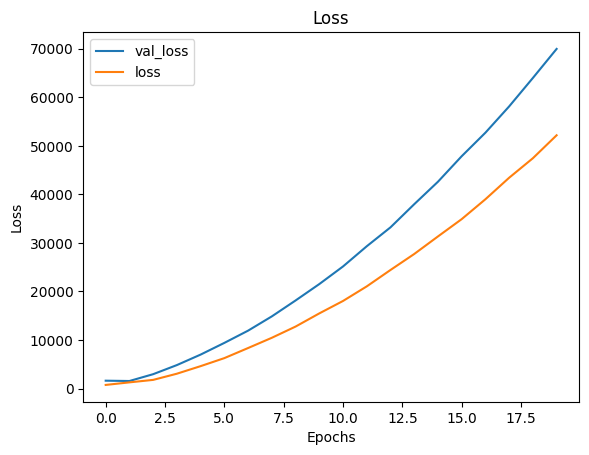

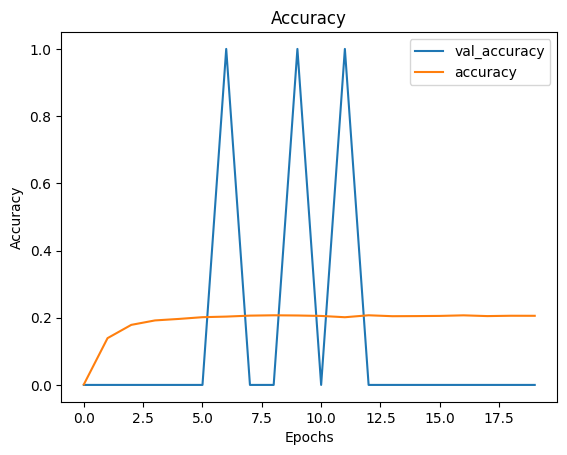

In [54]:
visualizing_training_results(results3)

From the above plots the model performance is worse compared to the first and second model. The accuracy is low and the loss values are very high. The accuracy plot shows overfitting due to the large gap between the training and the validation plots.

## Model 4 - Adding regularization to the RESNET50 Model

To try and address the overfitting issue, l2 regularization was applied in a bid to improve the performance of the model

In [64]:

# Training the model
history = model4.fit(train_generator, epochs=10, validation_data=validation_data)

Epoch 1/10
47/47 [==============================] - 147s 3s/step - loss: 39.2856 - accuracy: 0.0000e+00 - val_loss: 63.4128 - val_accuracy: 0.0000e+00
Epoch 2/10
47/47 [==============================] - 139s 3s/step - loss: 95.4160 - accuracy: 0.0000e+00 - val_loss: 128.4113 - val_accuracy: 0.0000e+00
Epoch 3/10
47/47 [==============================] - 138s 3s/step - loss: 161.4859 - accuracy: 0.0027 - val_loss: 196.0004 - val_accuracy: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 140s 3s/step - loss: 228.4881 - accuracy: 0.1680 - val_loss: 264.4967 - val_accuracy: 0.0000e+00
Epoch 5/10
47/47 [==============================] - 139s 3s/step - loss: 276.2502 - accuracy: 0.2213 - val_loss: 309.9553 - val_accuracy: 0.0000e+00
Epoch 6/10
47/47 [==============================] - 142s 3s/step - loss: 297.7416 - accuracy: 0.2507 - val_loss: 321.1191 - val_accuracy: 0.9360
Epoch 7/10
47/47 [==============================] - 141s 3s/step - loss: 291.4295 - accuracy: 0.2847 - va

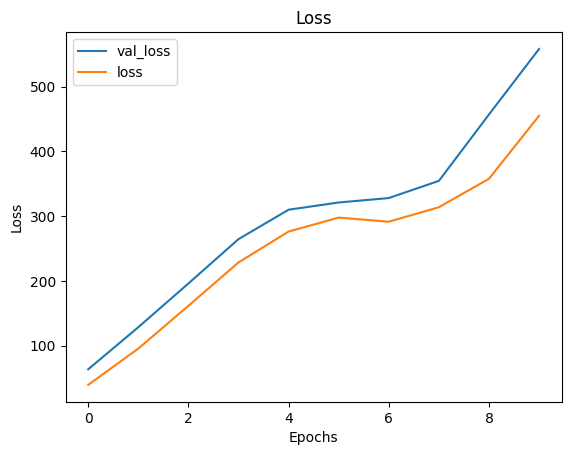

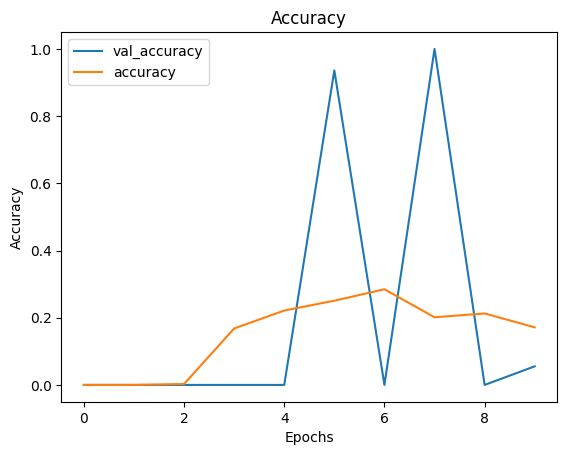

In [65]:
visualizing_training_results(history)

The model performance increased slightly since the accuracy value increased for both the training and validation. However the application of l2 regularization did not deal with the issue of overfitting. The loss values are still very high and they increase as the number of epochs increase

# Evaluation

Text(0, 0.5, 'Accuracy Values')

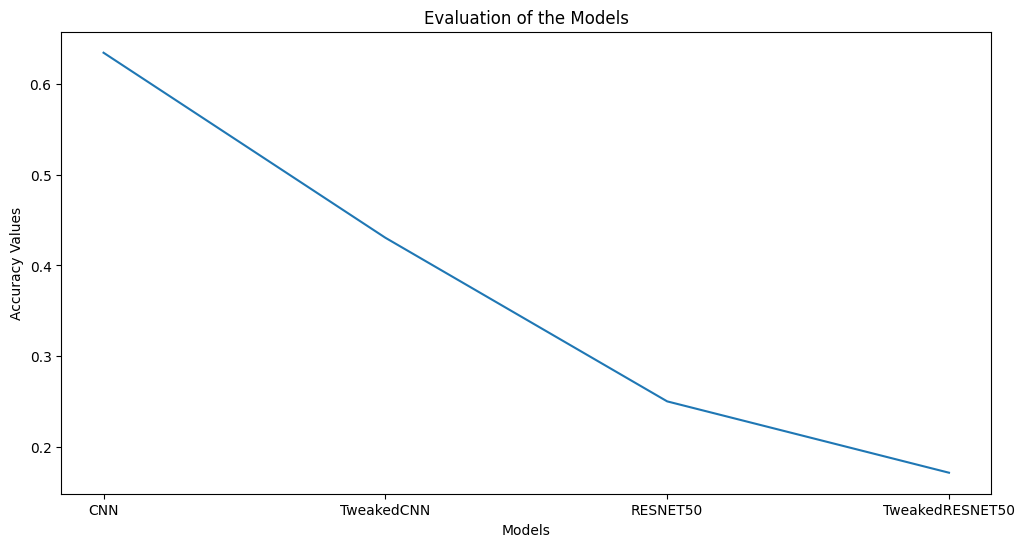

In [59]:
train_accuracy_values = [0.6346,0.4305,0.2500,0.1713]
models = ['CNN','TweakedCNN','RESNET50','TweakedRESNET50']

fig,ax = plt.subplots(figsize=(12,6))
plt.plot(models,train_accuracy_values)
plt.title('Evaluation of the Models')
plt.xlabel('Models')
plt.ylabel('Accuracy Values')

The line graph above shows how the different models performed based on their training accuracies. The best performing model was the Convolutional Neural Network using the RMSprop optimizer. The test accuracy was also higher relative to other models. 

# Recommendation

Medical practitioners should consider using a CNN model to make accurate and prompt diagnoses for patients who have suffered abdominal trauma. The CNN model exhibited the highest training accuracy during model development, indicating its potential for effective image classification in this context. 


# Conclusion

Leveraging the CNN model using the Adam classifier as the primary predictive model for image classification can assist medical practitioners to make accurate and fast diagnosis on patients with abdominal trauma. This has the potential to substantially improve patient care and health outcomes in emergency settings.